# Types & Mechanisms of Global Explainers

설명변수가 모형의 예측값에 기여하는 정도와 각 설명변수가 변화할 때 예측치의 변화추이를 파악하는 것은 모형을 설명하고 이해하는데 필수적이다. 이번 장에선 설명변수의 중요도를 파악하는 **Global Explainer**에 대해 알아본다.

### Global Explainer  
**Global Explainer** 는 전체 데이터에서 차지하는 설명변수의 중요도를 파악하는 explainer를 말한다. 대표적인 global explainer로는 PD(Partial Dependence), PV(Partial Variance), PI(Permutation Importance), ALE(Accumulated Local Effect) 등이 있다.  

**PD**와 **ALE**는 설명변수가 변화할 때 모형 예측값의 변화 추이를 보여주는 explainer이다. PD는 설명변수들이 서로 독립이라는 가정을 하지만 ALE는 이러한 가정이 없다.  
**PV**와 **PI**는 설명변수의 중요도를 측정한다. PV는 PD를 기반으로 하지만 PI는 손실함수를 통해 각 설명변수의 중요도를 측정하는 explainer이다.

이번 장에서 알아볼 Global explainer를 간단히 표로 다시 살펴본다.  
<center>

| XAI  | Applicable Models(Black/White) | Explainer Type (Global/Local) | Task (Regression/Classification) | Data Type (Tabular/Text/Image) | Library | Etc |
|:----:|:------------------------:|:-----------------------------:|:-------------------------------:|:-----------------------------:|:-------:|:---:|
| **PD**   | Black-box                | Global                        | Regression+Classification       | Tabular                       | alibi   | 설명변수 간 독립성 가정 필요 |
| **PV**   | Black-box                | Global                        | Regression+Classification       | Tabular                       | alibi   | PD에 의존                 | 
| **ALE**  | Black-box                | Global                        | Regression+Classification       | 연속형 Tabular                 | alibi   | 설명변수 간 독립성 가정 없음 |
| **PI**   | Black-box                | Global                        | Regression+Classification       | Tabular                       | alibi,ELI5   | 손실함수와 목적 변수값이 필요 |

</center>


---

## PD : Partial Dependence

**PD**는 설명변수가 예측값에 미치는 영향의 측도로 가장 널리 사용되고 있는 global explainer 중 하나이다. PD는 2차원 텐서로 구성된 tabular 데이터에 적용가능한 explainer로 수식적으로는 다음과 같이 표현할 수 있다. 

$$
\displaystyle
PD(x_{i}) = E[f(x_{i},X_{-i})] = \int f(x_{i},x_{-i})p( x_{-i} | x_{i} )dx_{-i} \tag{1}
$$


<center>

| Notations           | 설명                                                      |
|:-------------------:|:--------------------------------------------------------:|
| *대,소문자*          | 대문자는 *확률변수(Random Variable)*, 소문자는 *관측치(Observation or Realization)* |
| $x=(x_{1},x_{2},...,x_{k})$ | 설명변수 set                                               |
| $f(x)$               | 사전에 학습된 머신러닝 모델 $f$의 예측값                 |
| $X_{-i}$             | 확률변수 $X_{1},X_{2}, ... , X_{k}$ 중 $X_{i}$를 제외한 모든 확률변수 |
| $x_{-i}$             | $X_{i}$의 관측치를 제외한 $X_{-i}$의 관측치              |

</center>

$(1)$의 직관적인 의미를 살펴보면, $x_{i}$ 이외의 모든 다른 설명변수에 대한 적분을 취하므로 $X_{-i}$의 효과를 지워버리고(partial out), 오직 **$\mathbf{x_{i}}$가 $\mathbf{f(x)}$에 미치는 영향**만 측정하게 된다.  
특정 변수에 대해 그 변수를 고정하고, 나머지 변수들의 평균적인 영향을 고려하는 방식이다. 예측 모델 $f$에서 해당 변수를 고정한 상태에서, 나머지 변수들의 조건부 분포를 기반으로 예측값을 계산한다.  
쉽게 말해서, 하나 또는 여러 개의 설명변수가 모델의 예측에 어떻게 영향을 미치는지 보고자 **관심있는 변수들은 변화시키고, 그 외의 변수들은 고정시켜 변화가 예측값에 미치는 영향을 측정한다.**

식 $(1)$에서 정의된 조건부분포 $p(x_{-i} | x_{i})$에서 설명변수들이 서로 독립이라는 가정 하에 다음과 기댓값의 형태로 근사적으로 구할 수 있다. (독립성 가정이 없으면 현실적으로 계산하기 어렵다.)
$$
PD(x_{i}) \approx \int f(x_{i},x_{-i})p( x_{-i})dx_{-i}
$$  
따라서 $PD(x_{i})$의 추정치는 다음과 같다.
$$
\widehat{PD(x_{i})} = \frac{1}{n}\sum_{j=1}^{n}f(x_{i},x^{(j)}_{-i})  \tag{2}
$$  
여기에서 $x^{(j)}_{-i}$는 학습데이터에서 임의로 추출된 $j$번째 $x_{i}$를 의미한다. $X_{i}$의 주변분포(marginal distribution)  $p(x_{i})$를 가장 잘 대표하는 데이터가 학습데이터이기 때문이다.  

$PD$는 두 개 이상의 설명변수에 대해서도 다음과 같이 구할 수 있다.
$$
\widehat{PD(x_{s})} = \frac{1}{n}\sum_{j=1}^{n}f(x_{s},x^{(j)}_{-s})
$$
예를 들어 $x=(x_{1},x_{2},x_{3},x_{4})$ 일 때, $x_{s}=(x_{1},x_{3})$이면 $x_{-s}=(x_{2},x_{4})$인 서로 배반인 사건들이다.

$(1)$의 기대값으로 $x_{-i}$의 효과를 제거하는 역할을 식$(2)$의 표본 추정치로 구현하기 위해서는 $x_{-i}$를 random sample로 $n$번 대체하여 평균을 구하면 된다. 이를 **랜덤화(randomization)** 라고 하며, 이러한 랜덤화로 $x_{-i}$가 목적변수 $y$에 대한 정보력을 제거하게 된다. 학습데이터에서 관측된 모든 $x_{i}$값에 대해 식 $(2)$의 PD를 구해 그림을 그리면 설명변수 $x_{i}$와 예측치의 관계를 볼 수 있다.  
만약 **분류 문제**인 경우 $PD$는 주어진 설명변수의 변화에 따라 **특정 class에 속할 확률를 계산**하게 된다.

### PD Example
쉽게 이해하기 위해 간단한 데이터셋으로 예시를 보인다.
<center>

| $X_{1}$ | $X_{2}$ | $X_{3}$ | $\hat{f}$ |
| :-----: | :-----: | :-----: | :-------: |
|    1    |    4    |    7    |    0.4    |
|    2    |    5    |    8    |    0.8    |
|    3    |    6    |    9    |    0.6    |

</center>

다음과 같이 설명변수가 3개에 관측치가 3개 있는 데이터셋을 머신러닝 모델에 학습시켰다. 여기서 우리는 $X_{1}$이 예측값에 주는 영향을 보고 싶다고 가정한다. 그러면 $PD$는 다음과 같이 계산할 수 있다.

<center>

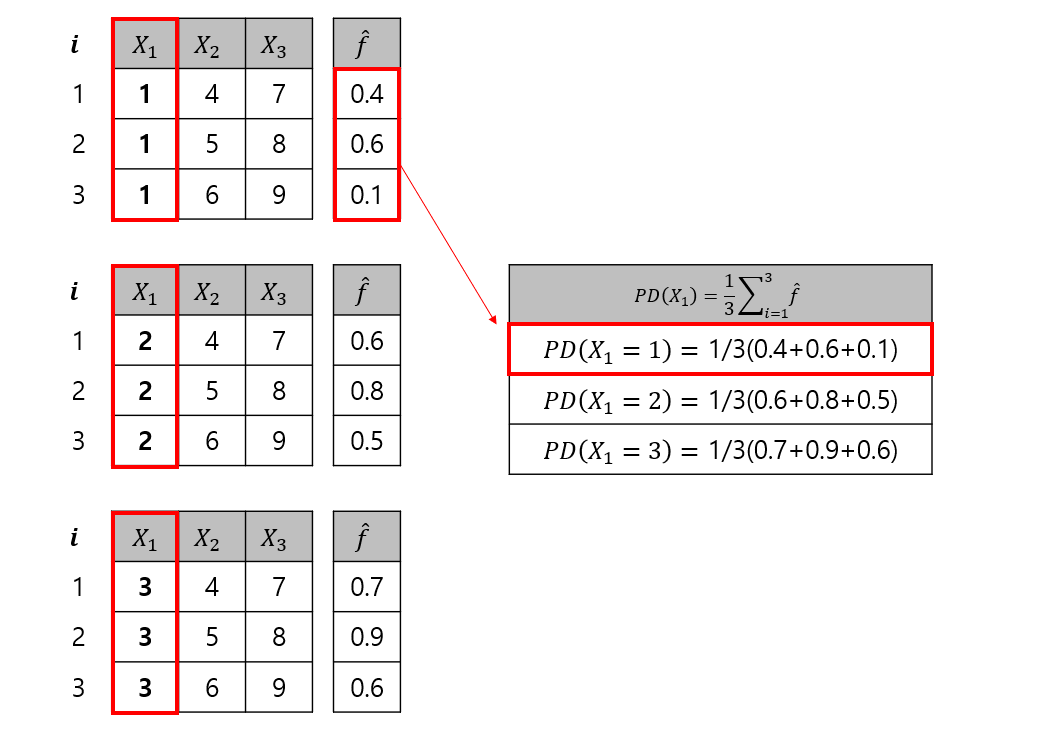

</center>

해당 그림에서 인덱스 $i$가 같은 관측치는 $ICE(Individual\ Conditional\ Expectation)$라고 부른다. $ICE$는  
$$
\widehat{PD(x_{i})} = \frac{1}{n}\sum_{j=1}^{n}f(x_{i},x^{(j)}_{-i})\ 에서 
$$  
$$ 
f(x_{i},x^{(-j)}_{i}),\  j=1,2,3...n\ 를\  의미한다.
$$ 
$ICE$는 각 개별 데이터 포인트에 대한 모델의 예측이 설명변수에 따라 어떻게 변화하는지를 의미한다. 따라서 $PD$는 $ICE$의 **평균**이며, $ICE$는 Local explainer임을 알 수 있다.  
**범주형 변수**에 대해서는 각 범주로 모두 바꿔가면서 다음과 같이 $PD$를 계산하게 된다.
<center>

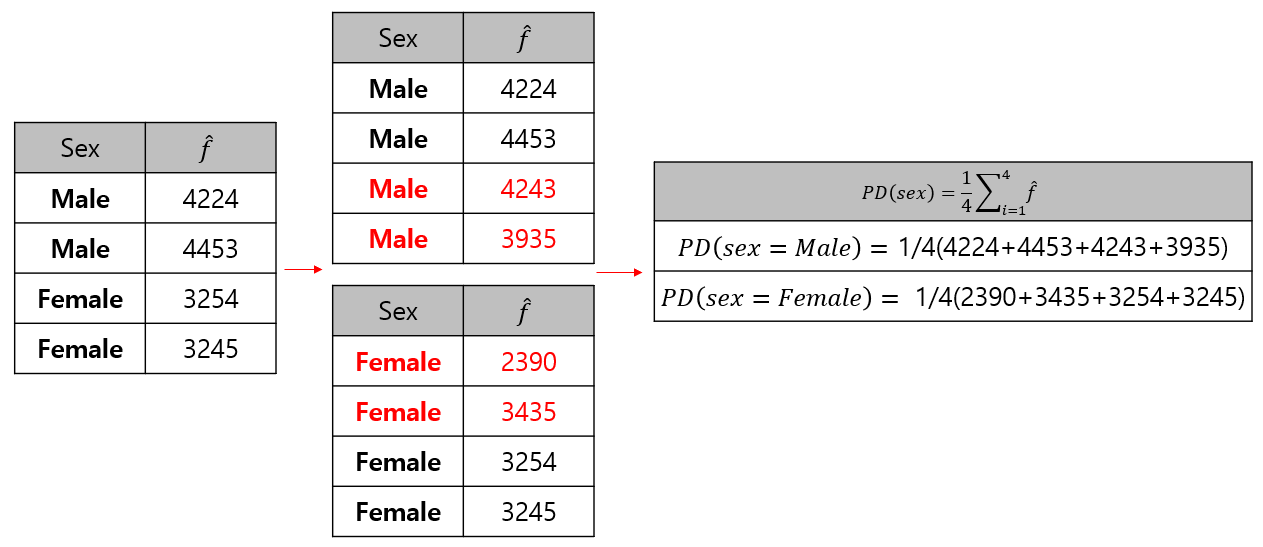

</center>


### More Issues about PD
오직 2개의 설명변수 $x_{1}$(몸무게), $x_{2}$ (키)가 있다고 가정할 때 몸무게의 효과를 보고 싶으면  
$$
\widehat{PD(x_{1})} = \frac{1}{n}\sum_{j=1}^{n}f(x_{1},x^{(j)}_{2})  \tag{2}
$$  
로 키에 대한 PD를 추정하게 된다. 그러나 몸무게를 $x_{1}$로 고정하고 키의 효과를 제거하기 위해 키를 임의로 추출하여 대입하면, 고정된 몸무게 30 $kg$에 키가 2m와 같은 현실적으로 불가능한 키와 몸무게의 조합들이 발생하여 머신러닝 모델 $f$가 학습하지 않은 경우들이 발생한다(Extrapolation,외삽). 몸무게와 키가 서로 간에 상관관계를 가지고 있음에도 불구하고 독립이라고 가정했기 때문에 발생한 현상이다.  
다음 그림을 보자. 주어진 데이터(검은색)을 살펴보면 $X1$과 $X2$는 선형적인 상관관계를 보이는 것을 추정할 수 있다. 하지만 $PD$는 주어진 데이터를 조합하여 다음과 같이 새로운 데이터(빨간색)를 생성한다. 우리의 모델 $f$는 주어진 데이터만 사용하여 학습한 모델인데 새로 조합되어 생성된 데이터를 모델 $f$에 넣어 나온 예측값들의 평균인 $PD$는 모델이 학습하지 못한 공간에 대한 예측값의 평균이므로 잘못된 해석을 야기할 수 있다.
<center>

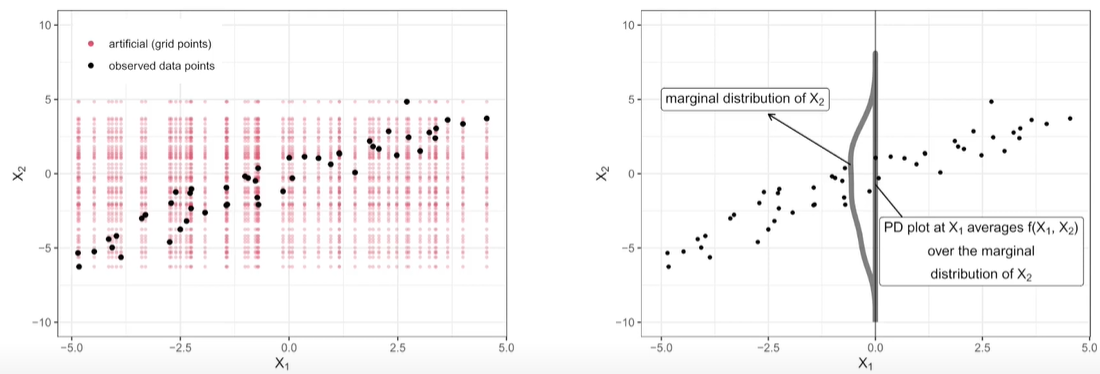

</center>

PD에서 발생하는 외삽 문제는 M-plot이라는, 조건부 기대값을 추정하는 방법을 통해 해결 할 수 있지만 여전히 상관관계가 존재할 때, 특정 변수의 marginal effect를 추정할 때, 상관관계가 있는 변수의 효과도 같이 포함되어 버리는 문제는 해결할 수 없다.

<center>

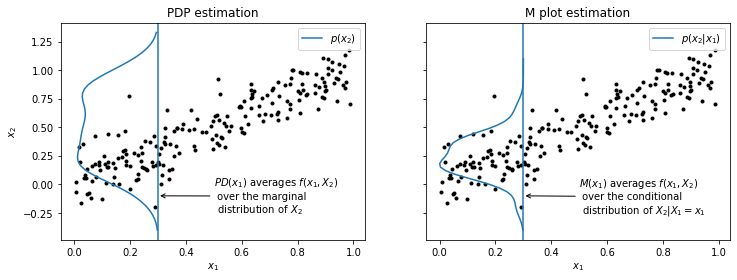

</center>


이러한 문제점을 보완한 것이 뒤에서 배울 $ALE$이다. $ALE$가 설명변수간 상관관계가 있는 경우를 다룰 수 있음에도, $PD$가 $ALE$에 비해 뛰어난 점들도 있다. $PD$는 $ALE$에 비해 직관적이고, 무엇보다 **범주형 변수**를 다룰 수 있다.

---

## PV : Partial Dependence Variance

$PV$는 앞에서 논의한 $PD$를 기반으로 계산되는 global explainer로 설명변수의 중요도를 측정한다. $PV$의 원리를 설명하기 위해 아래와 같이 6개의 설명변수에 대한 $PD$를 산출해 시각화한 그림을 살펴본다.  
$PD(x_{i})$를 관측된 모든 $x_{i}$에 대해 구하게 되므로 아래와 같이 시각화된다. 그림에서 볼 수 있듯이 상단부 3개 설명변수의 $PD$는 해당 설명변수가 변하면 예측값의 변동이 많은 반면, 하단부 3개 설명변수는 변하더라도 예측치의 변동이 거의 없는 것으로 보인다. 그러므로 **설명변수의 변동이 큰 설명변수는 예측값에 대한 기여도가 크다고 할 수 있다.**  
$PV$는 각 설명변수 값에 따라 측정된 $PD$들의 **표준편차**로 정의되며 $PV$가 크면 클수록 해당 설명변수의 중요도(importance)는 점점 커지게 된다.

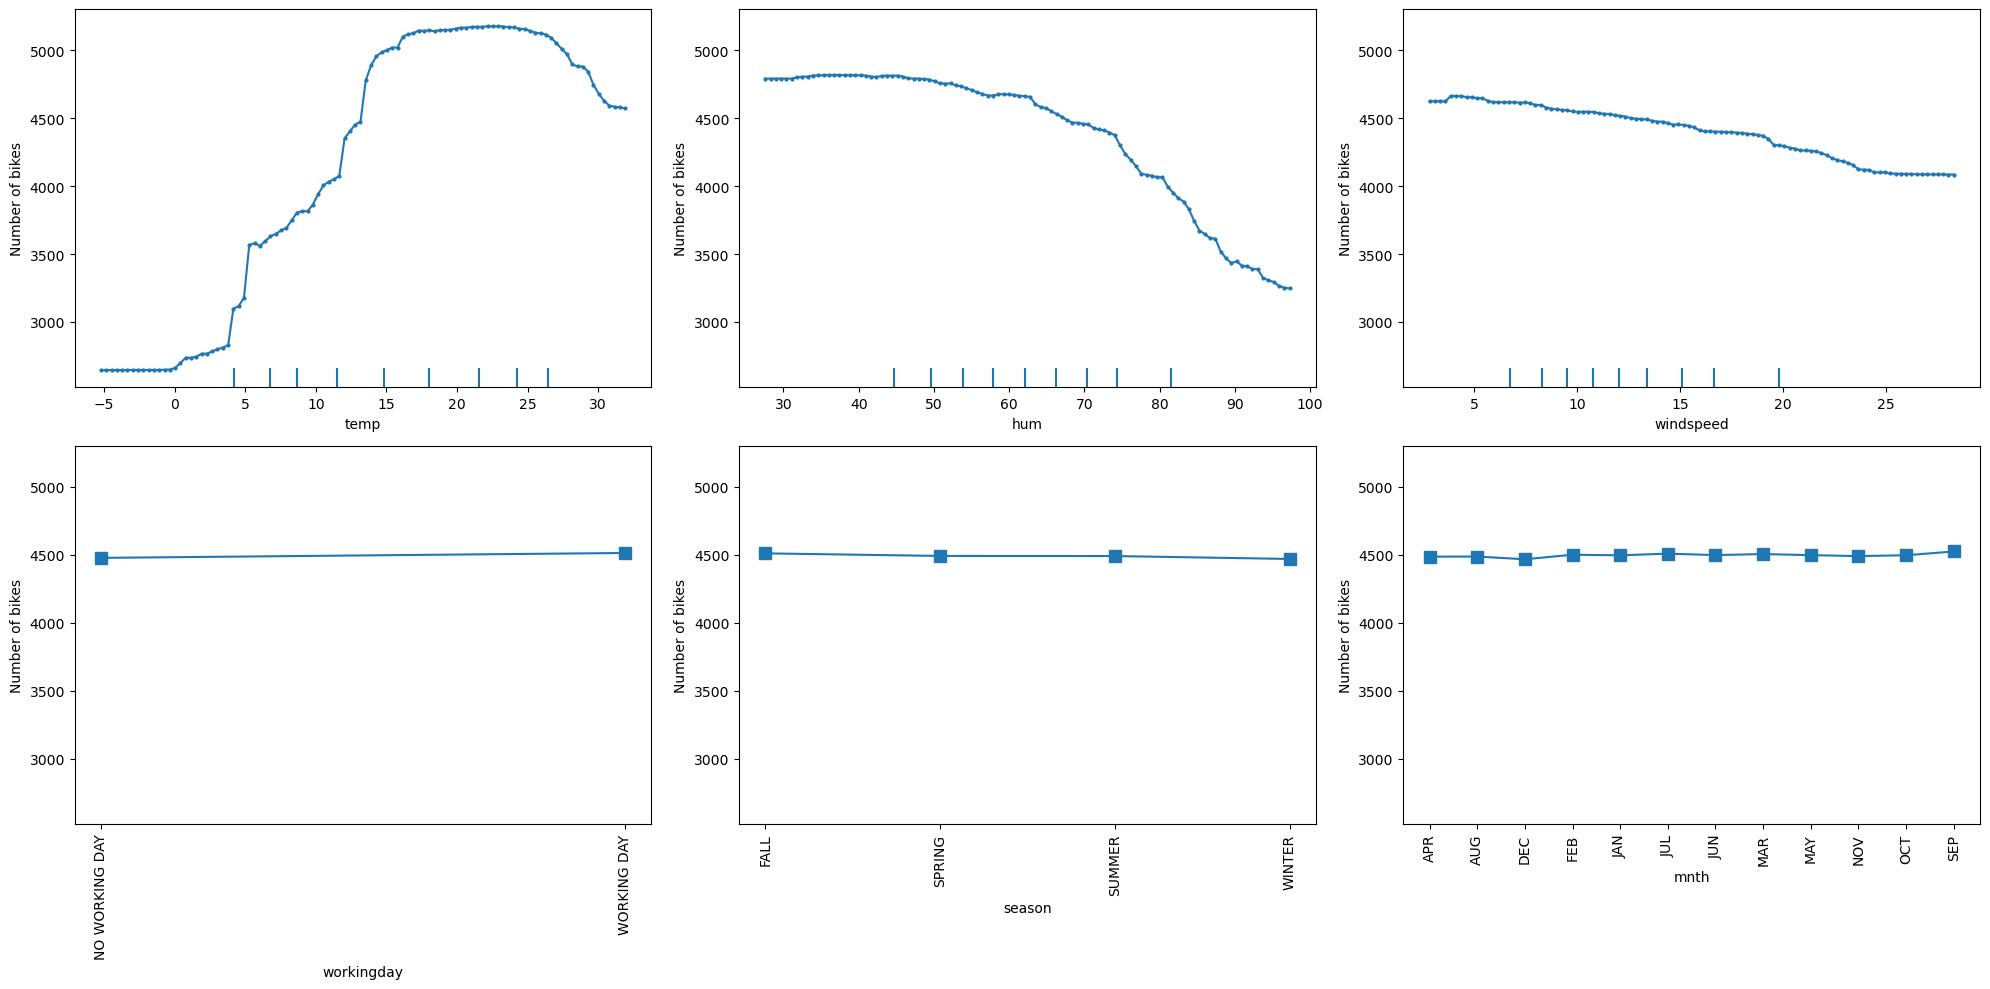

예를 들어 $x_{1} = 5,10,2,8,20$ 의 값을 가질 때, [$PD(x_{1}=5),\ PD(x_{1}=10),...\  ,PD(x_{1}=20)$]을 추정한 후 이 $PD$들의 표준편차가 $PV(x_{1})$이 된다. 두 개 이상의 설명변수에 대해서도 $PD(x_{s})$의 표준편차를 구하면 이 값이 교호작용에 대한 $PV(x_{s})$가 된다.  
만약 설명변수가 범주형이면 설명변수 $x_{i}$의 $PV$는 다음과 같이 구한다.
$$
[max_{j}PD(x^{(j)}_{i})-min_{j}PD(x^{(j)}_{i})]/4
$$  
여기서 $x^{(j)}_{i}$는 $x_{i}$의 j번쨰 관측치이고 $max_{j}PD(x^{(j)}_{i})-min_{j}PD(x^{(j)}_{i})$는 범위이므로 $\frac{범위}{4}$는 연속형 변수의 표준편차 추정치이기 때문에 범주형 설명변수의 $PV$가 된다.

---

## ALE : Accumulated Local Effect
$ALE$는 설명변수가 독립이라는 가정에서 구한 $PD$의 단점을 보완한 global explainer이다. 위에서 언급한 PD의 단점에서부터 나온 Motivation은 다음과 같다.
- **관심있는 변수외의 다른 변수들의 효과를 없애기 위해, 예측 함수를 관심 변수에 대해 편미분을 하고 다시 적분(누적합)을 하면 된다.**  

예시로 다음과 같은 예측함수를 가지고 있고, $x_1$에 관심이 있다고 해보자.
$$
\hat{f}(x_1,x_2)\ =\ 2x_1+2x_2-4x_1x_2
$$

1. 먼저 예측함수 $\hat{f}$를 $x_1$에 대해서 편미분을 실시한다.
$$
\frac{\partial\hat{f}(x_1,x_2)}{\partial x_1} = 2-4x_2
$$

2. 다음으로 편미분한 예측함수를 관심변수 $X_1$에 대해 적분한다. ($z_0=min(x_1)$)
$$
\int_{z_0}^{X}2-4x_2dx_1 
$$

해당 미분을 실시하면 $x_2$는 상수로 취급되어 결국 사라지므로, 결국 $x_2$의 효과는 사라지고 관심변수 $x_1$의 효과만 남게 된다.

이제부터 $ALE$에 대한 설명을 시작한다. 쉬운 이해를 위해 오직 2개의 설명변수 $x_{1}$과 $x_{2}$만 있다고 가정하자 그러면 $x_{1}$의 non-centered $ALE$는 다음과 같다.
\begin{align}
NC\_ALE(x_1) &= \int_{\min(x_1)}^{x_1} E\left( \frac{\partial f(X_1, X_2)}{\partial X_1} \middle| X_1 = z_1 \right) dz_1 \notag \\
&= \int_{\min(x_1)}^{x_1} \int \left[ \frac{\partial f(z_1, x_2)}{\partial z_1}p(x_2 \mid z_1)\right] dx_2 dz_1 \tag{3}
\end{align}
식 $(3)$에서 $\partial f(z_{1},x_{2})$를 선형화(linearization)하여 표현하면
$$
f(z_{1},x_{2})\ -\ f(z_{0},x_{2})
$$
이고 식 $(3)$의  
$$
E(\partial f(z_{1},X_{2})) = \int_{}^{}\partial f(z_{1},x_{2})p(x_2|z_1)dx_2
$$
이므로 $E(\partial f(z_{1},X_{2}))$는 $E(f(z_{1},X_{2})-f(z_{0},X_2))$ 로 변하게 된다. $X_1=z_1$로 주어진 조건부 확률을 반영하기 위해 $X_1$을 작은 간격(small interval) $z_0 \sim z_1$에 고정하고 해당 interval 내에 관측되는 모든 $X_2$의 가능한 값의 평균을 구한다.  
즉, $x_1$이 작은 interval($z_0 \sim z_1$)만큼 변할 때 $X_2$에 대한 기댓값 $E(f(z_{1},X_{2})-f(z_{0},X_2))$은 $X_2$의 $f$에 대한 효과를 제거한 $x_1$만의 순수 $f$의 변화량이 된다.  

$x_1$의 작은 구간 $z_0 \sim z_1$ 내에 있는 $X_2$에 대한 기대값을 취하므로 $x_1$과 $x_2$의 상호의존관계를 반영하여 설명변수 간의 독립성 가정이 불필요하다. 이런 관점에서 $E(f(z_{1},X_{2})-f(z_{0},X_2))$를 설명변수 $x_1$의 **local effect** 라고 한다. local effect를 $\int_{min(x_1)}^{x_1}$ (최소값부터 $x_1$까지 누적합) 하므로 ***accumulated***라는 이름이 붙여젔다.  
<center>

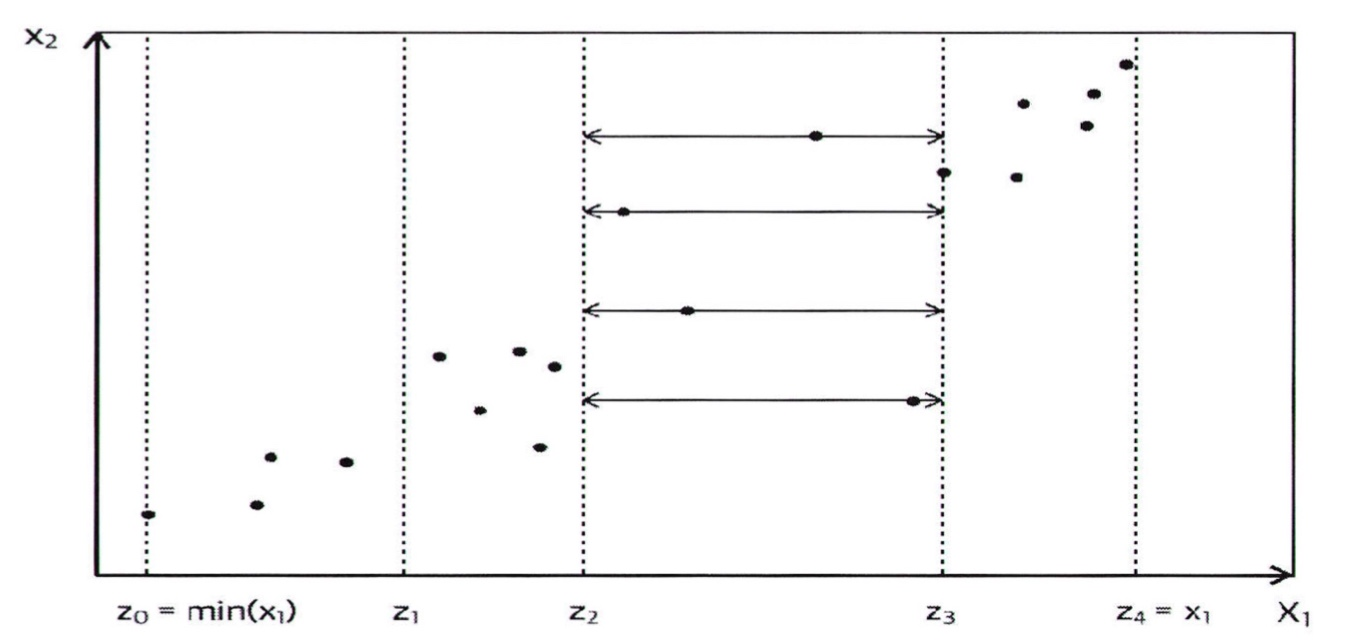

</center>

위의 그림과 같이 $min(x_1)=z_0$부터 관측치 $z_4=x_1$까지 네 등분(보통은 quantile)하여 각 등분 내의 $x_1$과 $x_2$의 좌표점을 ●으로 표시하고 있다. 등분 내의 표본 수는 $[z_{i-1},z_i)$ 내의 표본 수로 정의한다. 예를 들어 위의 그림 $[z_{1},z_2)$는 4개의 표본이 있는 것을 볼 수 있다. 구간 $[z_{i-1},z_i)$를 $I(i)$로 표기하며, $I(i)$ 안에 있는 표본 수는 $n(i)$로 정의한다.  
위 그림의 $I(3)$을 살펴보면 $x_1$의 좌표점을 2개의 좌표점($z_2,z_3$)으로 재정의한다. 하나는 $I(3)$의 하한점인 $z_2$로 이동하고, 다른 하나는 상한점인 $z_3$으로 이동한 것을 볼 수 있다. 즉, $I(3)$ 내에 있는 $x_1$의 좌표점은 모두 $z_2$와 $z_3$으로 이동하지만, $x_2$는 원래의 좌표점을 그대로 유지하고 있는 것을 볼 수 있다. 이런 과정을 $I(1) \sim I(4)$에 대해 동일하게 실행한다. 그러면 식 $(3)$에 정의된 $NC\_ALE(x_1)$은 다음과 같이 추정할 수 있다.

\begin{align*}
\displaystyle
\widehat{NC\_ALE}(x_1) &= \sum_{k=1}^{k(x_1)} \frac{1}{n(k)} \sum_{i \in I(k)} \left[ f\left(z_k, x_2^{(i)}\right) - f\left(z_{k-1}, x_2^{(i)}\right) \right] \tag{4}
\end{align*}

<center>

| Notations           | 설명                                                      |
|:-------------------:|:--------------------------------------------------------:|
| $k(x_1)$            | $min(x_1)$에서 $x_1$까지의 분할 수 (그림에서 $k(x_1)=4$)     | 
| $x^{(i)}_1$,$x^{(i)}_2$         | 설명변수 $x_1$,$x_2$의 $i$번째 관측치           |

</center>

식 $(4)$에서 $\sum_{i \in I(k)} \left[ f\left(z_k, x_2^{(i)}\right) - f\left(z_{k-1}, x_2^{(i)}\right) \right]$는 $I(k)$ 내에 있는 표본점 ($z_{k-1},x^{(i)}_2$)와 ($z_k, x_2^{(i)}$)를 넣어 구한 예측치 $f$의 변동치들의 합계이다. 여기서 합계는 $x^{(i)}_2$에 대한 합계이므로 $n(k)$를 나누면 식 $(3)$의 조건부 기댓값 $p(x_2 \mid z_1)$이 된다.  
식 $(4)$는 중심화되지 않은, 즉 $min(x_1)$에 의존하는 Non-Centerd $ALE$이므로 이를 중심화할 필요가 있다. 중심화 $ALE$는
$$
ALE(x) = 식(3)\ -\ E(NC\_ALE(X))
$$
로 정의되므로 중심화된 $ALE$의 추정치는
\begin{align*}
\widehat{ALE}(x_1) &= \sum_{k=1}^{k(x_1)} \frac{1}{n(k)} \sum_{i \in I(k)} \left[ f\left(z_k, x_2^{(i)}\right) - f\left(z_{k-1}, x_2^{(i)}\right) \right] - \frac{1}{n}\sum_{j=1}^{n}\widehat{NC\_ALE}(x^{(j)}_1)
\end{align*}
가 된다. 여기서 $x^{(j)}_1$는 $x_1$의 j번째 관측치이다.

$ALE$는 오직 설명변수가 실수형일 때만 적용될 수 있으며 현재까지 범주형 변수에 대한 $ALE$는 연구되지 않았다.  
조금 더 구체적인 계산과정이 궁금하면 해당 [동영상](https://youtu.be/xFS8Re9df9c?t=760)이 잘 정리했으니 참고하면 좋을듯 하다.

마지막으로 $ALE$의 장점과 단점에 대해 설명한다.
<center>

| **장점**                                          | **단점**                                       |
|:--------------------------------------------------:|:-----------------------------------------------:|
| $ALE$는 설명변수들 간 상관관계가 있어도 $Unbiased$하다. | 구간의 개수는 정해진 정답이 없으므로 다양한 구간 개수를 시도해가면서 확인해야 한다. |
| $ALE$는 $O(n)$ 시간복잡도를 가지며 이는 $PD$보다 빠르다. | $PD$와 비교했을 때 훨씬 복잡하고 직관성이 떨어진다. |
| $ALE$는 0에 중심화되어 있어 해석이 용이하다.         | 범주형 변수에 대한 $ALE$는 아직 연구되지 않았다. |

</center>

---

## PI : Permutation Importance

어떤 머신러닝 모형에 입력된 설명변수가 예측값에 미치는 영향을 파악하기 위한 가장 쉬운 방법은 관심있는 설명변수를 제거한 후, 모형을 재적합하여 모든 설명변수를 사용한 원래 모형의 성능과 비교하여 관심있는 설명변수의 중요도를 구하면 된다. 그러나 이러한 방법은 모형을 재적합해야 하므로 설명변수가 많아지거나 모형이 복잡하면 계산 부담이 커서 현실적으로 사용할 수 없다.
계산 부담을 줄일 수 있는 방법은 모든 설명변수를 입력하여 학습시킨 모형을 재사용하는 방법이다. $j$번째 설명변수를 제거하는 것과 동일한 효과를 주는 방법은 모든 표본의 $j$번째 설명변수에 random noise를 추가하면 $j$번째 설명변수는 더는 예측값에 기여하는 정보를 주지 못하게 된다.  이러한 random noise는 $j$번째 설명변수와 동일한 분포를 갖는 noise가 아니면 편향(bias)이 존재하므로, 데이터에 있는 j번째 설명변수를 **shuffling(permuting)** 하면 해당 설명변수에 random noise를 추가한 것과 동일한 효과를 가지게 된다.  
이러한 shuffling을 설명변수별로 $n$번 반복하여 모형성능 차이를 평균내면 이 값이 설명변수별 중요도가 된다. 이를 $PI(Permutation\ Importance)$라고 한다

서로 간에 독립인 확률변수 $Z^{(a)} = (Y^{(a)},X^{(a)}_1,X^{(a)}_2)$와 $Z^{(b)} = (Y^{(b)},X^{(b)}_1,X^{(b)}_2)$ 가 있다고 가정하자. 그런데 이 두 개의 확률 변수는 동일한 다변량 분포 $F$로부터의 확률변수로, 분포적으로 동일하다. 다음의 두 가지 손실함수 기댓값을 고려해보자. 

\begin{align*}
e_{\text{org}}(M) &= E(L(M, Y^{(a)}, X_1^{(a)}, X_2^{(a)})) \\
&= E_{Y^{(a)}, X_1^{(a)}, X_2^{(a)}} L(M, Y^{(a)}, X_1^{(a)}, X_2^{(a)}) \\
&= \iiint L(M, y^{(a)}, x_1^{(a)}, x_2^{(a)}) p(y^{(a)}, x_1^{(a)}, x_2^{(a)}) \, dy^{(a)} \, dx_1^{(a)} \, dx_2^{(a)}.
\end{align*}

\begin{align*}
e_{\text{switch}}(M) &= E(L(M, Y^{(a)}, X_1^{(b)}, X_2^{(a)})) \\
&= E_{Y^{(a)}, X_1^{(b)}, X_2^{(a)}} L(M, Y^{(a)}, X_1^{(b)}, X_2^{(a)}) \\
&= \iiint L(M, y^{(a)}, x_1^{(b)}, x_2^{(a)}) p(y^{(a)}, x_1^{(b)}, x_2^{(a)}) \, dy^{(a)} \, dx_2^{(a)} \, dx_1^{(b)} \\
&= \iiint L(M, y^{(a)}, x_1^{(b)}, x_2^{(a)}) p(y^{(a)}, x_2^{(a)}) p(x_1^{(b)}) \, dy^{(a)} \, dx_2^{(a)} \, dx_1^{(b)} \\
&= \iiint \left[ L(M, y^{(a)}, x_1^{(b)}, x_2^{(a)}) p(x_1^{(b)}) \, dx_1^{(b)} \right] p(y^{(a)}, x_2^{(a)}) \, dy^{(a)} \, dx_2^{(a)}.
\end{align*}

<center>

| Notations    |   설명  |
|:------------:|:-------:|
| $X_1,X_2$    | 설명변수를 나타내는 확률변수 | 
| $Y$          | 목적 변수이며, 확률변수로 이해|
| $M$          | 머신러닝 모형 |
| $L$          | 손실함수 |

</center>

$e_{switch}(M)$의 의미를 살펴보면, $X^{(b)}_1$는 $X^{(a)}_1$와 동일한 주변분포(marginal distribution)을 가지고 있으나 $Y^{(a)}$와는 독립이므로 $X^{(b)}_1$는 $X^{(a)}_1$와 다르게 $Y^{(a)}$에 대한 정보가 전혀 없는 확률변수로 바꾼(switch) 손실함수의 기대치이다. 즉, $e_{switch}(M)$에서는 고정된 $y^{(a)}$와 $x^{(a)}_2$에서 $X^{(b)}_1$에 적분하여 $x^{(b)}_1$의 정보를 제거(partial out)했으므로 오직 $Y^{(a)}$를 오직 $X^{(a)}_2$로만 예측하는 $M(X^{(a)}_2)=\hat Y$이 되므로, **$e_{switch}(M)$는 이 $\hat Y$와 $Y^{(a)}$의 차이를 측정하는 손실함수의 기댓값이다.**  
한편, $e_{org}(M)$는 $Y^{(a)}$에 대한 정보를 가지고 있는 $X^{(a)}_1$, $X^{(a)}_2$를 모두 이용한 $Y^{(a)}$의 예측값 $M(X^{(a)}_1, X^{(a)}_2)$로 구한 손실함수의 기댓값으로 해석할 수 있다. 그러므로 $e_{org}(M)$에서 $Y^{(a)}$에 대한 $X^{(a)}_1$의 기여도가 크면 클수록 $e_{switch}(M)$는 커지게 된다.

$e_{switch}(M)$의 크기를 $e_{org}(M)$에 대비한 상대적 크기로 측정해야 하므로 Fisher et al. (2019)는 다음과 같은 의존비(reliance ratio) $MR$과 의존차이(reliance difference) $MR_{diff}$를 제안했다.  
$$
MR(M)=\frac{e_{switch}(M)}{e_{org}(M)}
$$

$$
MR_{diff}(M)=e_{switch}(M)\ -\ e_{org}(M)
$$

$MR$의 값은 다음과 같이 3가지 경우로 해석할 수 있다.
- $MR(M)>1$ 은 우리의 모델이 $X_1$에 의존한다는 의미이다. 예를 들어 $MR(M)=2$면 $X_1$이 permutation이 되었을 때 손실함수가 2배가 증가했다는 의미이다.
- $MR(M)=1$ 은 모형이 $X_1$에 의존하지 않는다는 의미이며 $X_1$이 permute되어도, 손실함수에는 영향이 없다는 의미이다.
- $MR(M)<1$ 은 모형이 $X_1$에 부적절하게 의존하며, permutation을 했을 때 오히려 손실함수가 감소한다. 이 경우는 조금 특이한데, 실제로 $X_1$과 $Y$가 음의 상관관계를 가지는데 모델은 양의 상관관계로 인식하는 경우 이런 현상이 발생하며, 이는 우리가 더 나은 모델, 즉 $MR(M')=1$이 되는 더 나은 모델을 찾을 수 있음을 의미한다.
 
이런 관점에서 설명변수의 $PI$는 $MR(M)$이나 $MR_{diff}$값으로 산출된다. 가장 큰 $MR$이나 $MR_{diff}$ 값을 가진 설명변수가 가장 중요한 설명변수가 된다.  

$e_{switch}(M)$와 $e_{org}(M)$를 추정하기 위해, 학습데이터의 $i$번째 표본의 목적변수를 $y_{i}$, 설명변수를 ($x_{1i},x_{2i}$)로 표기한다. 여기에서 $x_{1i}$와 $x_{2i}$는 모두 1차원 이상의 설명변수를 나타내지만, 각 설명변수의 $PI$를 구할 때는 $x_{1i}$는 1차원을 가정한다. 이러한 notation을 이용하여 다음과 같이 $e_{org}(M)$와 $e_{switch}(M)$를 추정하여 $MR$과 $MR_{diff}$에 대입한다.
$$
\hat e_{org}(M)=\frac{1}{n}\sum_{i=1}^{n}L(M,y_i,x_{1i},x_{2i})
$$

$$
\hat e_{switch}(M)=\frac{1}{n(n-1)}\sum_{i=1}^{n}\sum_{j\neq i}^{n}L(M,y_j,x_{1i},x_{2j})
$$

이러한 관점으로 볼 때, $Z^{(a)} = (Y^{(a)},X^{(a)}_1,X^{(a)}_2)$는 학습데이터이고 $X^{(b)}_1$는 학습데이터의 $x_1$를 permuting 해서 구한 값으로 대응시킬 수 있다. 그러므로 $\hat e_{org}(M)$는 $n$개의 학습데이터를 그대로 사용하는 반면, $\hat e_{switch}(M)$는 $x_1$을 permuting해서 계산한 값이다. 단, permuting한 $x_1$이 목적변수 $y$에 대한 정보를 갖지 않도록 원래의 관측치 쌍을 갖는 $x_{1i}$는 제외한다.  

$e_{switch}(M)$은 표본의 크기 $n$이 크면 계산 부담이 매우 크다는 단점이 있기에 이에 대한 대안은 다음과 같다.  
$$
\hat{e}_{\text{bisec}}(M) = \frac{1}{2\lfloor n/2 \rfloor} 
\sum_{i=1}^{\lfloor n/2 \rfloor} 
\Big[
L(M, y_i, x_{1,i+\lfloor n/2 \rfloor}, x_{2i}) 
+ L(M, y_{i+\lfloor n/2 \rfloor}, x_{1i}, x_{2,i+\lfloor n/2 \rfloor})
\Big]
$$

$\hat{e}_{\text{bisec}}(M)$는 학습데이터를 임의로 이등분하여 $(y,x_2)$는 첫 이등분값, $(y,x_1)$은 두 번째 이등분값으로 짝지어 손실함수를 구하고 반대로 짝지어 손실함수를 구한 후, 평균을 계산하여 산출한다.

$PI$의 장점과 단점을 정리한 표를 마지막으로 보며 Global explainer의 이론을 마무리한다.
<center>

| **장점**                                            | **단점**                                       |
|:--------------------------------------------------:|:-----------------------------------------------:|
| $PI$는 해석이 용이하다.                    | $PD$와 비슷한 이유로, Permutation에서 불가능한 값이 발생하여 편향(bias)가 발생할 수 있다. |
| $PI$는 모델을 재학습시킬 필요가 없다.        | 성능 지표에 따라 해석이 크게 달라질 수 있다. |
| $PI$는 다른 설명변수와의 교호작용을 고려한다. |  |

</center>

---

### 참고자료
[PartialDependence](https://docs.seldon.io/projects/alibi/en/stable/methods/PartialDependence.html)  
[PartialDependenceVariance](https://docs.seldon.io/projects/alibi/en/stable/methods/PartialDependence.html)  
[AccumulatedLocalEffect](https://docs.seldon.io/projects/alibi/en/stable/methods/ALE.html)  
[PermutationImportance](https://docs.seldon.io/projects/alibi/en/stable/methods/PermutationImportance.html)